In [1]:
# python import
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter, ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm       # ColorMaps
%matplotlib inline

np.random.seed(seed=1)


# Define the dataset

In [2]:

number_of_samples_per_class = 20
blue_mean = [0]
red_left_mean = [-2]
red_right_mean = [2]

std_dev = 0.5

# generate sample from both classes
x_blue = np.random.randn(number_of_samples_per_class, 1) * std_dev + blue_mean
x_red_left = np.random.randn(int(number_of_samples_per_class/2), 1) * std_dev + red_left_mean
x_red_right = np.random.randn(int(number_of_samples_per_class/2), 1) * std_dev + red_right_mean

# Marge samples in set of input variables x, and corresponding set of output variables t
x = np.vstack((x_blue, x_red_left, x_red_right))
t = np.vstack((np.ones((x_blue.shape[0],1)), 
               np.zeros((x_red_left.shape[0],1)), 
               np.zeros((x_red_right.shape[0], 1))))


# Plot the samples from both classes as lines on a 1D space

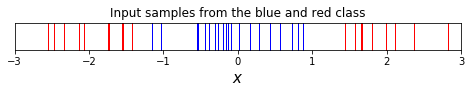

In [3]:

plt.figure(figsize=(8, 0.5))
plt.xlim(-3, 3)
plt.ylim(-1,1)
# plot samples
plt.plot(x_blue, np.zeros_like(x_blue), 'b|', ms=30)
plt.plot(x_red_left, np.zeros_like(x_red_left), 'r|', ms = 30) 
plt.plot(x_red_right, np.zeros_like(x_red_right), 'r|', ms = 30) 
plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Input samples from the blue and red class')
plt.xlabel('$x$', fontsize=15)
plt.show()

In [4]:
# define the rbf function
def rbf(z):
    return np.exp(-z**2)

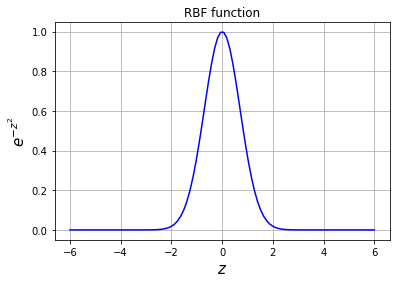

In [6]:
# plot the rbf function
z = np.linspace(-6, 6, 100)
plt.plot(z, rbf(z), 'b-')
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$e^{-z^2}$', fontsize=15)
plt.title('RBF function')
plt.grid()
plt.show()

# Optimization by backpropagation

In [7]:
"""Forward Step"""
# define the logistic function
def logistic(z):
    return 1 / (1 + np.exp(-z))

# function to compute the hidden activations
def hidden_activations(x, wh):
    return rbf(x * wh)

# define output layer feedforward
def output_activations(h, wo):
    return logistic(h*wo -1)

# define the neural network function
def nn(x, wh, wo):
    return output_activations(hidden_activations(x, wh), wo)

# define the neural network prediction function that only returns 1 or 0 depending on the predicted class
def nn_predict(x, wh, wo):
    return np.around(nn(x, wh, wo))

In [8]:
"""Backward Step"""
def cost(y, t):
    return - np.sum(np.multiply(t, np.log(y)) + np.multiply((1-t), np.log(1-y)))

def cost_for_param(x, wh, wo, t):
    return cost(nn(x, wh, wo), t)

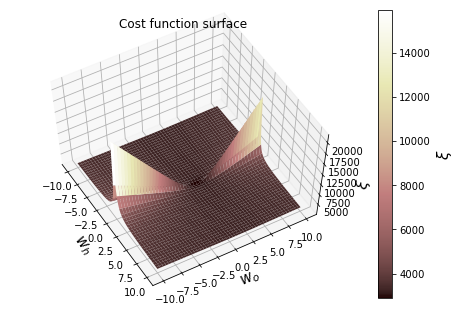

In [9]:
# Plot the cost in function of the weights
# Define a vector of weights for which we want to plot the cost
nb_of_ws = 200 # compute the cost nb_of_ws times in each dimension
wsh = np.linspace(-10, 10, num=nb_of_ws) # hidden weights
wso = np.linspace(-10, 10, num=nb_of_ws) # output weights
ws_x, ws_y = np.meshgrid(wsh, wso) # generate grid
cost_ws = np.zeros((nb_of_ws, nb_of_ws)) # initialize cost matrix
# Fill the cost matrix for each combination of weights
for i in range(nb_of_ws):
    for j in range(nb_of_ws):
        cost_ws[i,j] = cost(nn(x, ws_x[i,j], ws_y[i,j]) , t)
# Plot the cost function surface
fig = plt.figure()
ax = Axes3D(fig)
# plot the surface
surf = ax.plot_surface(ws_x, ws_y, cost_ws, linewidth=0, cmap=cm.pink)
ax.view_init(elev=60, azim=-30)
cbar = fig.colorbar(surf)
ax.set_xlabel('$w_h$', fontsize=15)
ax.set_ylabel('$w_o$', fontsize=15)
ax.set_zlabel('$\\xi$', fontsize=15)
cbar.ax.set_ylabel('$\\xi$', fontsize=15)
plt.title('Cost function surface')
plt.grid()
plt.show()

# Define the error function

In [17]:
# Define the error function
def gradient_output(y, t):
    return y - t

# Define the gradient function for the weight parameter at the output layer
def gradient_weight_out(h, grad_output): 
    return  h * grad_output

# Define the gradient function for the hidden layer
def gradient_hidden(wo, grad_output):
    return wo * grad_output

# Define the gradient function for the weight parameter at the hidden layer
def gradient_weight_hidden(x, zh, h, grad_hidden):
    return x * -2 * zh * h * grad_hidden

# Define the update function to update the network parameters over 1 iteration
def backprop_update(x, t, wh, wo, learning_rate):
    # Compute the output of the network
    # This can be done with y = nn(x, wh, wo), but we need the intermediate 
    #  h and zh for the weight updates.
    zh = x * wh
    h = rbf(zh)  # hidden_activations(x, wh)
    y = output_activations(h, wo)
    # Compute the gradient at the output
    grad_output = gradient_output(y, t)
    # Get the delta for wo
    d_wo = learning_rate * gradient_weight_out(h, grad_output)
    # Compute the gradient at the hidden layer
    grad_hidden = gradient_hidden(wo, grad_output)
    # Get the delta for wh
    d_wh = learning_rate * gradient_weight_hidden(x, zh, h, grad_hidden)
    # return the update parameters
    return (wh-d_wh.sum(), wo-d_wo.sum())

# Run backPropagetion

In [18]:
# Set the initial weight parameter
wh = 2
wo = -5
# Set the learning rate
learning_rate = 0.2

# Start the gradient descent updates and plot the iterations
nb_of_iterations = 50  # number of gradient descent updates
lr_update = learning_rate / nb_of_iterations # learning rate update rule
w_cost_iter = [(wh, wo, cost_for_param(x, wh, wo, t))]  # List to store the weight values over the iterations
for i in range(nb_of_iterations):
    learning_rate -= lr_update # decrease the learning rate
    # Update the weights via backpropagation
    wh, wo = backprop_update(x, t, wh, wo, learning_rate) 
    w_cost_iter.append((wh, wo, cost_for_param(x, wh, wo, t)))  # Store the values for plotting

# Print the final cost
print('final cost is {:.2f} for weights wh: {:.2f} and wo: {:.2f}'.format(cost_for_param(x, wh, wo, t), wh, wo))

final cost is 3253.05 for weights wh: 59.73 and wo: 22.00
